In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))

In [3]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z')
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
            #    + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))
# system.energy = mm.DMI(D=4e-3, crystalclass='Cnv_z')

In [4]:
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='Cnv_z') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Zeeman(H=(0, 0, 200000.0))

In [8]:
Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

In [36]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/07/27 20:22]... (6.2 s)


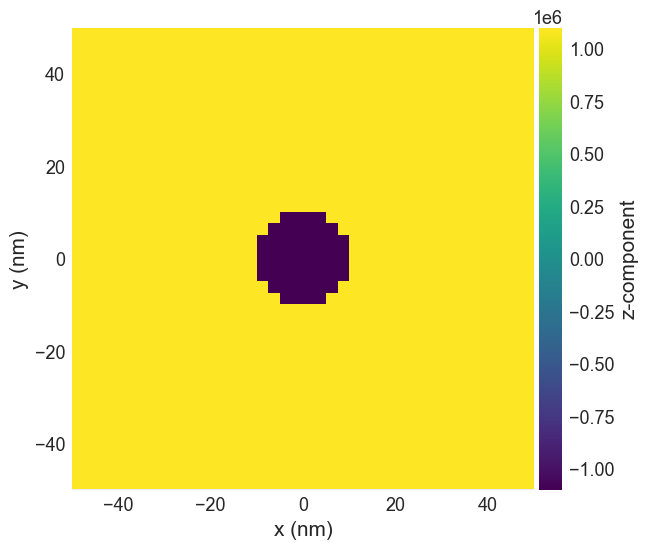

In [9]:
system.m.plane('z').mpl()

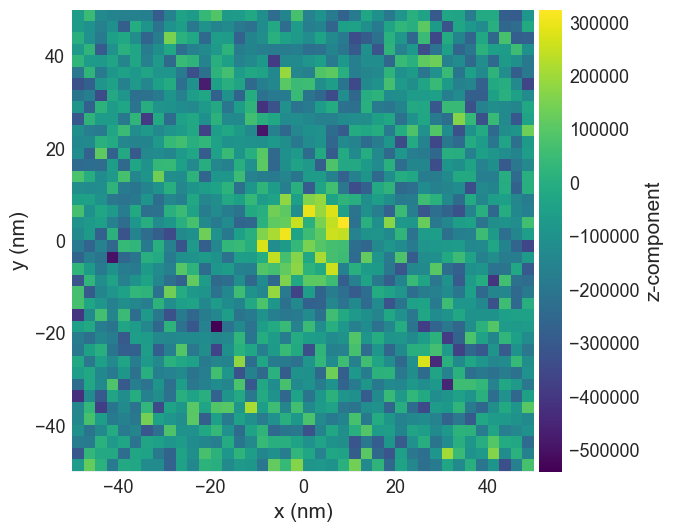

In [7]:
# create some noise in the system inside the cylinder
array = system.m.array
array = array*np.random.normal(-0.1, 0.1, array.shape)

# set new magnetisation
system.m.array = array
# Plot z-component only:
system.m.plane('z').mpl()

In [16]:
class MCDriver2():
    def __init__(self, system) -> None:
        self.m0 = 4*np.pi*1e-7 # Tm/A
        magnitudes = np.linalg.norm(system.m.array, axis=-1)
        magnitudes[magnitudes == 0] = 1 #avoid division by zero
        self.grid = system.m.array/magnitudes[..., np.newaxis] #normalise vectors to get m(r)
        self.grid = np.pad(self.grid, ((1, 1),(1, 1), (1, 1), (0, 0)), mode='wrap') #Periodic boundary conditions
       
        self.dx, self.dy, self.dz = system.m.mesh.cell
        self.temperature = system.T + 1e-12 #avoid division by zero
        self.Kb = 1.38064852e-23 #Boltzmann constant
        # What about multiple similar energy terms????
        try:
            self.zeeman_K = system.energy.zeeman.H
        except:
            self.zeeman_K = None
        try:
            self.exchange_A =  system.energy.exchange.A
        except:
            self.exchange_A = None
        try:
            self.dmi_D = system.energy.dmi.D
            self.type = system.energy.dmi.crystalclass
        except:
            self.dmi_D = None
        try:
            self.anisotropic_K, self.anisotropic_u = (system.energy.uniaxialanisotropy.K, np.array(system.energy.uniaxialanisotropy.u))
        except:
            self.anisotropic_K, self.anisotropic_u = (None, None)
        try:
            self.demag_N = system.energy.demag.N
        except:
            self.demag_N = None

        # self.energy = self.total_energy(grid=self.grid) # energy of the system for each cell
            

    def zeeman_energy(self, grid):

        energy = -self.m0*Ms*np.dot(grid[1:-1, 1:-1, 1:-1], self.zeeman_K)*self.dx*self.dy*self.dz
        return energy

    
    def anisotropic_energy(self, grid): # only uniaxial anisotropy is supported
        
        energy = np.cross(grid[1:-1, 1:-1, 1:-1], self.anisotropic_u)
        energy = self.anisotropic_K*np.sum(np.sum(energy**2, axis=-1))*self.dx*self.dy*self.dz #total energy of the system

        return energy
    
    def exchange_energy(self, grid):

        laplacian_M = (((grid[2:, 1:-1, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[:-2, 1:-1, 1:-1])/self.dx**2) + \
                       ((grid[1:-1, 2:, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, :-2, 1:-1])/self.dy**2) + \
                       ((grid[1:-1, 1:-1, 2:] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, 1:-1, :-2])/self.dz**2)
                    )
                    
        energy = np.sum(grid[1:-1, 1:-1, 1:-1]*laplacian_M) #dot product of m and laplacian_M
        energy = -self.exchange_A*energy*self.dx*self.dy*self.dz #total energy of the system
        return energy
    
    def dmi_energy(self, grid):
       
        #calculate gradient of z component of m vector with respect to each axis
        gradM_z = np.empty_like(grid, dtype='float64')

        gradM_z[..., 0] = (grid[2:, 1:-1, 1:-1, 2] - grid[:-2, 1:-1, 1:-1, 2]) / (2 * self.dx)
        gradM_z[..., 1] = (grid[1:-1, 2:, 1:-1, 2] - grid[1:-1, :-2, 1:-1, 2]) / (2 * self.dy)
        gradM_z[..., 2] = (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)


        #divergence of m vector
        div_M = ( (grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx) +
                (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy) +
                (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)
                )
        
        m_del_mz = np.sum(grid[1:-1, 1:-1, 1:-1]*gradM_z, axis=-1) #dot product of m and gradient of z component of m vector
        mz_div_m = self.grid[1:-1, 1:-1, 1:-1, 2]*div_M  # mz∇⋅m

        energy = self.dmi_D * (np.sum(m_del_mz) - np.sum(mz_div_m)) * self.dx * self.dy * self.dz #Total energy of the system
       
        return energy
    
    
    def driver(self, N):
        # cell_energy = np.zeros((3, 3, 3)) #energy of small grid

        for _ in range(N):
            # 1. Randomly select a cell
            cell_x, cell_y, cell_z = np.random.randint(0, self.grid.shape[:3])
          
            while np.all(self.grid[cell_x , cell_y, cell_z] == 0): #if the cell is empty, select another cell
                cell_x, cell_y, cell_z = np.random.randint(0, self.grid.shape[:3])
            
            # check if the cell is within 2 cells from the boundary
            if 2 <= cell_x <= self.grid.shape[0] - 3 or 2 <= cell_y <= self.grid.shape[1] - 3 or 2 <= cell_z <= self.grid.shape[2] - 3:
                small_grid = self.grid[cell_x-2:cell_x+3, cell_y-2:cell_y+3, cell_z-2:cell_z+3]
            else:
                #create a padding for self.grid with 2 cells
                grid = np.pad(self.grid, ((2, 2), (2, 2), (2, 2), (0, 0)), mode='edge')
                cell_x, cell_y, cell_z = (cell_x + 2, cell_y + 2, cell_z + 2)
                small_grid = grid[cell_x-2:cell_x+3, cell_y-2:cell_y+3, cell_z-2:cell_z+3]
            print(small_grid.shape)
            
            E_before = self.zeeman_energy(grid=small_grid) + self.exchange_energy(grid=small_grid) + self.dmi_energy(grid=small_grid) + self.anisotropic_energy(grid=small_grid)

            # 3. energy before the change
            prev_direction = np.copy(small_grid[1, 1, 1])

            # 4. randomly select a direction
            direction = small_grid[1, 1, 1] + np.random.uniform(-0.1, 0.1, size=3)
            direction = direction/np.linalg.norm(direction) #normalise the direction vector
            small_grid[1, 1, 1] = direction
            
            # 5. energy after the change
            E_after = self.zeeman_energy(grid=small_grid) + self.exchange_energy(grid=small_grid) + self.dmi_energy(grid=small_grid) + self.anisotropic_energy(grid=small_grid)

            delta_E = E_after - E_before #change in energy

            # 6. Decision
            if delta_E < 0: #if energy is lower than previous energy, accept the change
                pass
            else: #if energy is higher than previous energy, accept the change with probability exp(-dE/kT)
                if np.random.uniform(0, 1) < np.exp(-(delta_E)/(self.Kb*self.temperature)):
                    pass
                else:
                    #reject the change
                    small_grid[1, 1, 1] = prev_direction #revert the change 
                    
        return self.grid

In [17]:
# How can I apply better approximation of central difference?
# compare the anisotrophic energy with other's implementation 
mc1 = MCDriver2(system)

In [18]:
new_grid1 = mc1.driver(1000000)

(5, 5, 5, 3)


ValueError: could not broadcast input array from shape (3,3,3) into shape (5,5,5)

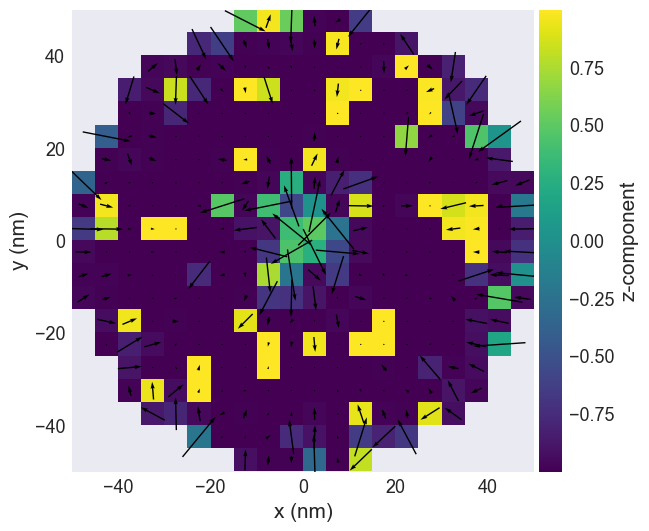

In [50]:
system.m.array = new_grid1[1:-1, 1:-1, 1:-1]

system.m.plane('z').mpl()